In [1]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from fitter import Fitter
from prophet import Prophet
# from fitter import Fitter, get_common_distributions, get_distributions
# import numpy as np
# Not available in current interpreter
# from ydata_profiling import ProfileReport as ydata_prof
# from pandas_profiling import ProfileReport as pd_prof
# Not available in current interpreter
# from ydata_profiling import ProfileReport as ydata_prof
# from pandas_profiling import ProfileReport as pd_prof
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

#### Data Prep
1.Converting the date column from the csv to datetime is necessary for Prophet to run.

2.The date columns must be in 2023-12-31 format.

3.The date column should be renamed to 'y' and the date column should be renamed to 'ds'.

4.Forecast works well with simply the date and revenue, but more variables can be added.

In [2]:
df = pd.read_csv('C:/Users/norri/Desktop/tyson.csv')
# CRUCIAL FOR PROPHET TO WORK
df['ds'] = pd.to_datetime(df['ds'])

## Initial Data Exploration

#### Basic statistical checks for time-series
1. Describing a pandas dataframe with the df.describe() function
2. If the data column contains nulls, the analysis will be difficult if not impossible.
3. In the assignments column which has many small or zero values assignments, we see a low mean, a high max, and most other values as zeroes. The EDA can both confirm and call into question the validitiy of the data.
4. As seen in this data, when there are few columns that are predominantly zeroes, it make interpreting fundamental tests of the data difficult

1.This .info() function is necessary that there are no null values, all columns are the same length, and the date column is datetime.

2.The .describe() function is necessary to see the mean, max, and other statistical values of the data. It can also give you ideas as to whether a column is oversaturated with zeroes.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22712 entries, 0 to 22711
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ds           22712 non-null  datetime64[ns]
 1   y            22712 non-null  float64       
 2   assignments  22712 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 532.4 KB


In [4]:
df.describe()

,y,assignments
count,22712.000000,22712.000000
mean,4.665468,0.026374
std,4.998766,0.219398
min,0.390000,0.000000
25%,1.890000,0.000000
50%,2.980000,0.000000
75%,5.670000,0.000000
max,90.720000,2.000000


If there are null values, a small percentage could be imputed, but too many makes testing impossible. Note that imputing dates, especially in irrregular time-series data, is counterproductive at best.

In [5]:
print('Missing Values')
print(df.isnull().sum() / len(df) * 100)

Missing Values
ds             0.0
y              0.0
assignments    0.0
dtype: float64


Too many zeros in a column makes it difficult for the model to learn from the relationships with the other data.

In [6]:
print('Count of missing assignments')
missing_assignments = df['assignments'] == 0
# missing_units = df['units'] == 0
missing_y = df['y'] == 0

Count of missing assignments


In [7]:
print("Missing Assignments")
if missing_assignments.sum() > 0:
    print((df['assignments'] == 0).sum())
else:
    print(0)
    
# print("Missing Units")
# if missing_units.sum() > 0:
#     print((df['units'] == 0).sum())
# else:
#     print(0)
    
print("Missing y")
if missing_y.sum() > 0:
    print((df['y'] == 0).sum())
else:
    print(0)

Missing Assignments
22368
Missing y
0


The above datetime is a a crucial section right here. If the data has too many nulls, too many zeros reporting in a column or columns, the data will be difficult to use for forecasting. The histograms (though not in this data), will begive to provide a shape of the distributions and if transformations are necessary (among many other things).

## Intermediate EDA

In [8]:
# def corr_plot(df):
#     """
    # 
    # This provides a clean heatmap of correlations, though if too
    # many variables are in the dataset, it will b edifficult to read
    # """
    # corr_temp = df.drop(['ds'], axis=1)
    # corr_names = corr_temp.columns.tolist()
    # temp_df = df[corr_names]
    # corr = temp_df.corr(method="pearson").round(2)
    # mask = np.triu(np.ones_like(corr, dtype=bool))
    # f, ax = plt.subplots(figsize=(8, 8))
    # cmap = sns.diverging_palette(250, 1, as_cmap=True)
    # sns.heatmap(corr, annot=True, mask=mask, cmap=cmap,
    #             vmax=1, vmin=-1, center=0,
    #             square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    
# corr_plot(df)

It makes sense to  that revenue and units are correlated, but because we noticed so many zeros in the assignment column, we should further investigate that. It is also likely that due to the large number of zeros in the assignments column, correlations are being calculated incorrectly.

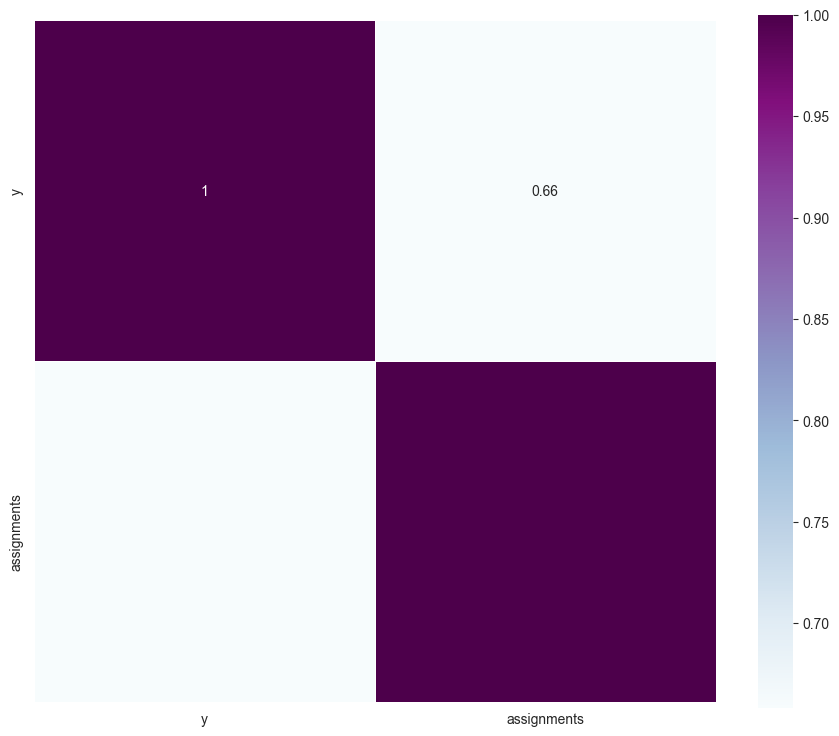

In [9]:
corr_all = df.drop('ds', axis=1).corr()

# Generate a mask for the upper triangle
# mask = np.zeros_like(corr_all, dtype = bool)
# mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, annot = True, 
            # mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show();

Used in conjuction with the correlation plot, the VIF can be used for extra proof to drop variables that are highly correlated. Generally, a VIF score of anu variable larger than 5 suggests at least one of the variables should be examined or transforned, and VIF above 10 may require drastic data modifications.

In [10]:
# df_vif = pd.read_csv('C:/Users/norri/Desktop/tyson.csv')
# 
# # Extract predictor variables (excluding the target variable)
# X = df_vif.drop('ds', axis=1)
# X = X.drop('y', axis=1)
# # Calculate VIF for each predictor variable
# vif = pd.DataFrame()
# vif['Variable'] = X.columns
# vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# 
# # Display variables with VIF > 5
# print(vif[vif['VIF'] > 5])
# print(vif)

#### Dickey-Fuller Test

The Dickey-Fuller test is a statistical test used to determine the presence of unit root in a time series. The null hypothesis of the test is that the time series can be represented by a unit root, which is non-stationary. Non-stationarity is a necessary assumption needed for time-series data; it describes the prcess where time-series data with probability attriubutes, such as mean and variance, do not change over time. If the data is non-stationary, it will be difficult to use for forecasting. The ADF is an improved version of the Dickey-Fuller test with looks for autoregressive properties beyond the previous lag. Autocorrelation, one of the other main concerns with time series data, is easier to identify by plotting.

In [11]:
# print('Unit Dickey-Fuller Test')
# series = pd.read_csv('C:/Users/norri/Desktop/LunchablesData.csv', header=0, index_col=0)
# X = series.units
# result = adfuller(X)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#  print('\t%s: %.3f' % (key, value))

In [12]:
# print('Assigments Dickey-Fuller Test')
# series = pd.read_csv('C:/Users/norri/Desktop/LunchablesData.csv', header=0, index_col=0)
# X = series.assignments
# result = adfuller(X)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#  print('\t%s: %.3f' % (key, value))

In [13]:
# print('Revenue (y) Dickey-Fuller Test')
# series = pd.read_csv('C:/Users/norri/Desktop/LunchablesData.csv', header=0, index_col=0)
# X = series.units
# result = adfuller(X)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#  print('\t%s: %.3f' % (key, value))

## Prophet Setup

In [14]:
df_train = df[df['ds'] <= '2024-03-31']
df_test = df[df['ds'] >= '2024-04-01']

This section sets all the parameters for the Prophet model. Setting the growth as linear for now, but worth experimenting with. Changepoints are locations where the rate of change is potentially allowed to change.
The yearly, weekly, and daily seasonality are set here as auto for yearly and weekly, so Prophet can detect it, and daily for false, so it doesn't detect any false readings. Seasonality mode is defined to as either additive or multiplicative for better fitting.
The following parameters are set to avoid overfitting. Note that at the end of the notebook there is a bit that runs a check on the priors.
Fit should be set to false to add extra regressors.
While some parameters are possible to adjust with little difficult, others, like changepoints, and more difficult and often are difficult to improve output.

In [15]:
m = Prophet(growth = 'linear',
            n_changepoints = 25,
            changepoint_range = 0.8,
            yearly_seasonality = 'auto',
            weekly_seasonality = 'auto',
            daily_seasonality = 'auto',
            # holidays = 'holidays',
            seasonality_mode = 'additive',
            seasonality_prior_scale = 10.0,
            holidays_prior_scale = 10.0,
            changepoint_prior_scale = 0.05,
            mcmc_samples = 800,
            interval_width = 0.20,
            uncertainty_samples = 500)
            # stan_backend = 'False',
            # fit = False)

m.add_country_holidays(country_name='US') 
m.fit(df_train)
# m.add_regressor('assignments, units')

08:43:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:07:51 - cmdstanpy - INFO - CmdStan done processing.
10:07:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: norma

10:07:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 398 iterations at max treedepth (99.5%)
	Chain 2 had 397 iterations at max treedepth (99.2%)
	Chain 3 had 399 iterations at max treedepth (99.8%)
	Chain 4 had 398 iterations at max treedepth (99.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


This creates a dataframe the same length of the input data to set parameters for training and before the data is split between training and testing data sets.

In [22]:
future = m.make_future_dataframe(periods=30)

Using the Prophet model, it makes it projects for 30 days.

In [23]:
forecast = m.predict(future)

## Prophet Model Diagnostics

There are many diagnostics that can be used along with the Prophet model (and many other time-series models as well). Prophet specifically provides plots to compare forecasts to actuals, RMSE and other fit metrics to compare between iterations of the models, as well as cross-validation and others.

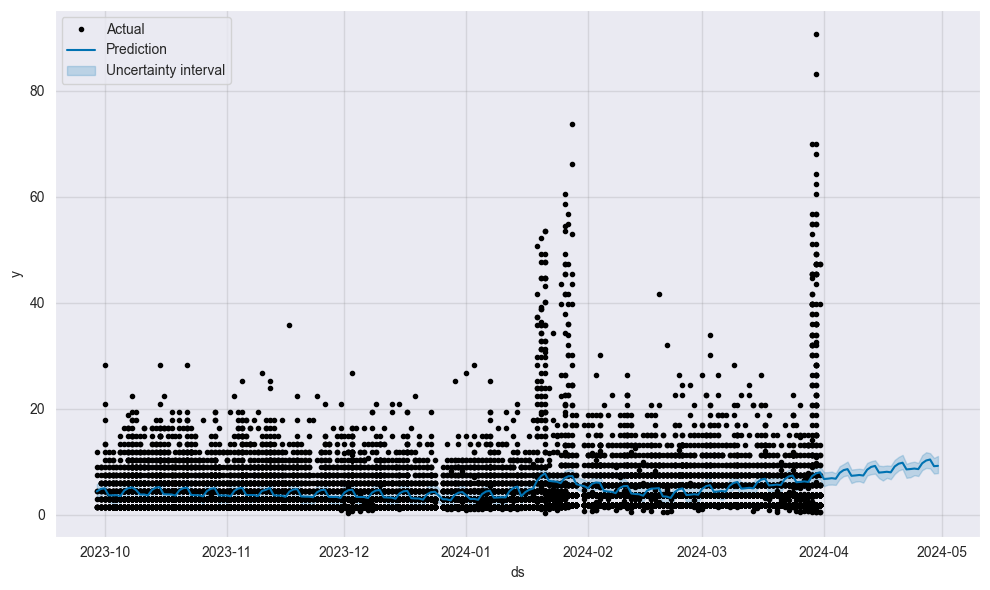

In [24]:
fig1 = m.plot(forecast)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval'])
plt.show()

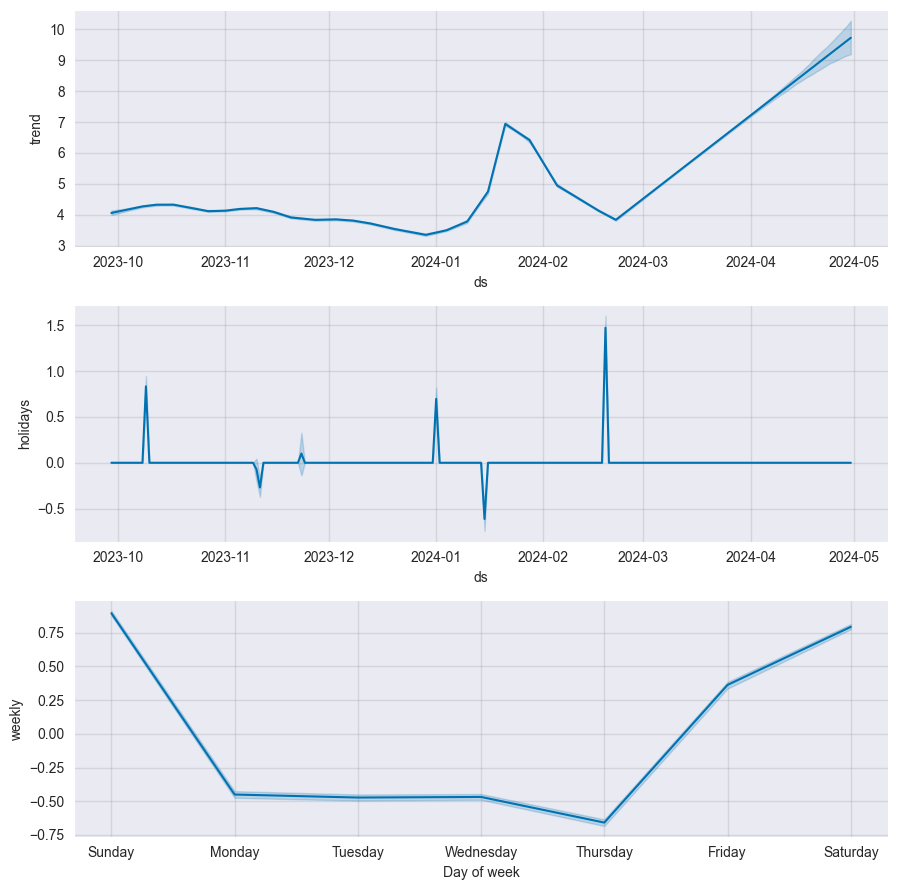

In [25]:
fig2 = m.plot_components(forecast)

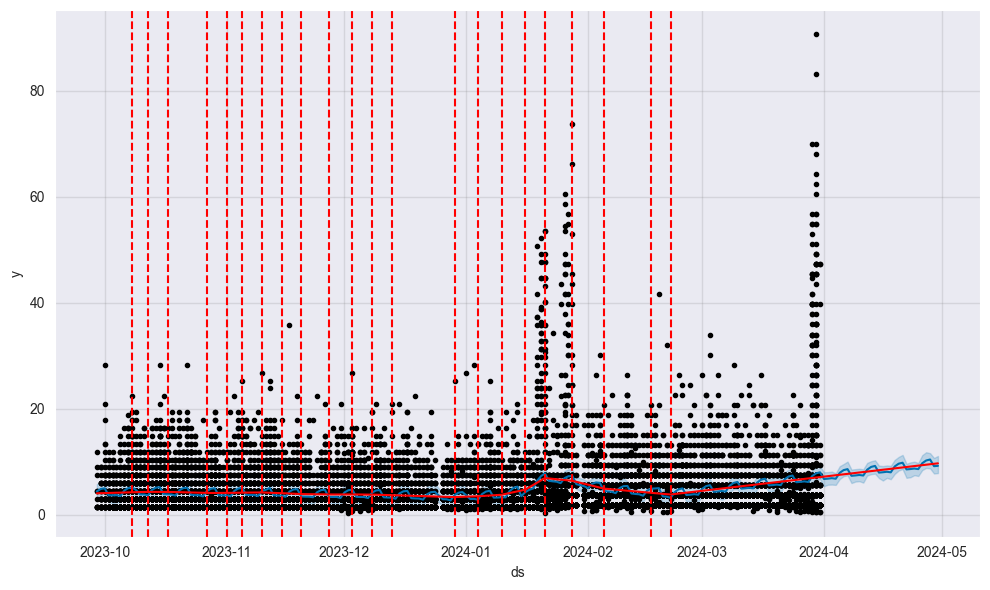

In [26]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

The cross_validation function here uses historical data to measure forecast error. The next function prints off the different measures it uses, like RMSE, SMAPE, etc.

In [27]:
predictions = forecast.iloc[-len(df_test):]['yhat']
actuals = df_test['y']
print(f"RMSE: {round(rmse(predictions, actuals))}")

ValueError: operands could not be broadcast together with shapes (213,) (2814,) 

In [28]:
# test period
# horizon = '30 Days'

# itraining period (optional. default is 3x of horizon)
# initial = str(365 * 5) + ' Days'  
# 
# # spacing between cutoff dates (optional. default is 0.5x of horizon)
# period = '365 days' 

In [ ]:
horizon = '30 Days'
df_cv = cross_validation(m, horizon=horizon, parallel='processes')

Optional parameters - there are many Prophet parameters that can improve a model (or get things messy), and you may some after this point.

In [ ]:
# df_cv = cross_validation(m, initial=None, period='90 days', horizon = '7 days')

In [ ]:
# performance metrics  
df_metrics = performance_metrics(df_cv)  # can define window size, e.g. rolling_window=365
df_metrics

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

This plots the difference between the forecast and the actuals.

In [ ]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [ ]:
# additive mode
m = Prophet(seasonality_mode='additive')
# multiplicative mode
# m = Prophet(seasonality_mode='multiplicative')

In [ ]:
plt.plot(forecast['yhat'], label='Forecast')
plt.plot(df['y'], label='Actuals')
leg = plt.legend()
plt.show()

Similar metrics to those from the cross_validation function could be used to compare the historical error to the model error.

In [ ]:
## Estimating the statistical distributions of each variable and fitting them to their original shape

In [ ]:
ds_df = df[['y', 'assignments', 'units']]

for var in ds_df:
    dist_test = ds_df[var].dropna()
    dist_test = dist_test.values
    f = Fitter(dist_test, distributions='common', bins=100, timeout=30)
    f.fit()
    print(var)
    print(f.summary(Nbest=3, clf=True, plot=True))
    print(f.get_best(method='sumsquare_error'))

In [ ]:
lower_q = df['y'].quantile(0.25)
upper_q = df['y'].quantile(0.75)
iqr = upper_q - lower_q
lower_bound = lower_q - (1.5 * iqr)
upper_bound = upper_q + (1.5 * iqr)
outliers = df['y'][(df['y'] < lower_bound) | (df['y'] > upper_bound)]
print("Mean of all y")
print(df['y'].mean())
print('Mean of all outliers')
print(outliers.mean())
print('Count of outliers')
print(outliers.count())

In [ ]:
print(outliers)
plt.plot(outliers)